In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 1
setup_one_gpu(GPU)

Picking GPU 1


In [2]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from general_tools.notebook.tf import reset_tf_graph

import tf_lab.point_clouds.in_out as pio

from tf_lab.point_clouds.in_out import PointCloudDataSet, write_model_ids_of_datasets

from tf_lab.point_clouds.autoencoder import Configuration as Conf

from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id
                                                  
from general_tools.in_out.basics import create_dir, files_in_subdirs

from general_tools.simpletons import select_first_last_and_k

from geo_tool import Point_Cloud

from tf_lab.point_clouds.gan import model_saver_id

from tf_lab.nips.shape_net import pc_loader as sn_pc_loader

from tf_lab.point_clouds.raw_gan import RawGAN

from tf_lab.point_clouds.generators_discriminators import mlp_discriminator, convolutional_discriminator,\
                                                          point_cloud_generator, leaky_relu, mlp_discriminator

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
save_model = True
save_synthetic_samples = True
class_name = raw_input('Give me the class type.\n').lower()
syn_id = shape_net_category_to_synth_id()[class_name]
synthetic_data_out_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/NIPS/our_samples/'

do_training = True
do_plotting = True
n_pc_samples = 2048

max_epochs = 1500
arch_tag = 'mlp_arch'
leak = 0.2
dropout_prob = 0.5

discriminator = mlp_discriminator
adaptive_training = None

beta = 0.5
disc_kwargs = {'non_linearity': leaky_relu(leak), 'dropout_prob': dropout_prob}
    
generator = point_cloud_generator
gen_kwargs = {'b_norm': False, 'layer_sizes':[64, 128, 256, 512, 1024], 'dropout_prob':dropout_prob}
experiment_name = class_name + '_'+ arch_tag + '_raw_gan_' + str(n_pc_samples) +  '_pts'

Give me the class type.
car


In [5]:
top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'
train_dir = osp.join(top_data_dir, 'OUT/models/nips/gan/raw_gan')
train_dir = osp.join(train_dir, experiment_name)
create_dir(train_dir)

full_pclouds_path = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Core/from_manifold_meshes/centered/', str(n_pc_samples))
full_pclouds_path = osp.join(full_pclouds_path, syn_id)
full_file_names = pio.load_filenames_of_input_data(full_pclouds_path, '.ply')
full_pclouds, full_model_ids, full_syn_ids = pio.load_crude_point_clouds(file_names=full_file_names,
                                                                           n_threads=25, loader=sn_pc_loader)
print '%d files containing complete point clouds were found.' % (len(full_pclouds), )

7497 files containing complete point clouds were found.


In [6]:
training_data = PointCloudDataSet(full_pclouds)

batch_size = 50
noise_params = {'mu':0, 'sigma': 0.5}
noise_dim = 512
init_lr = 0.0001

n_syn_samples = training_data.num_examples  # Same number as original GT data.

In [ ]:
reset_tf_graph()

gan = RawGAN(experiment_name, init_lr, [n_pc_samples, 3], noise_dim,
             discriminator, generator, beta=beta, gen_kwargs=gen_kwargs, disc_kwargs=disc_kwargs)

accum_syn_data = []
train_stats = []

1 (1.3756019229056851, 0.70465115892807106) 47.55123806
2 (1.3839104591600047, 0.69834661803789588) 47.1301970482
3 (1.3814390321705965, 0.70113025815694929) 47.675495863
4 (1.3721720212257948, 0.71350364197020566) 47.9555981159
5 (1.35599015943156, 0.73313733995360819) 48.1795370579
6 (1.3385413565091639, 0.76483212461407557) 47.9665658474
7 (1.3033298326018672, 0.82547005430964016) 48.0068039894
8 (1.2300667466733279, 0.93059684486197147) 47.9619441032
9 (1.2228864311371874, 1.021609132321889) 47.9563519955
10 (1.1150992818726788, 1.159247905215961) 48.1819698811
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/nips/gan/raw_gan/car_mlp_arch_raw_gan_2048_pts/models.ckpt-10 is not in all_model_checkpoint_paths. Manually adding it.


/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


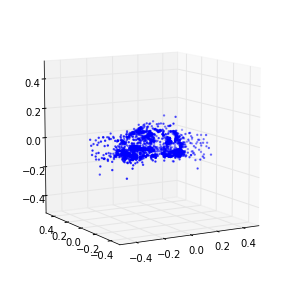

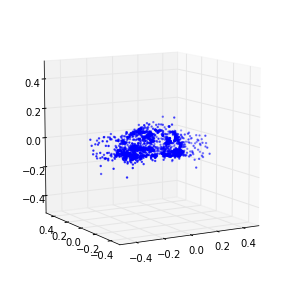

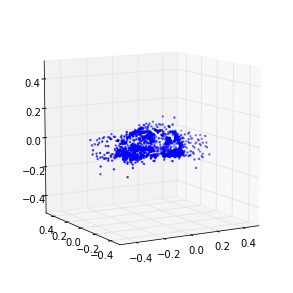

11 (1.122826835053079, 1.1215716652422143) 47.8953530788
12 (0.98171368881359999, 1.4423184290828321) 48.2139129639
13 (1.0473921106965749, 1.2750848959756378) 48.118555069
14 (0.83792136629555847, 1.6509639312756941) 47.9840669632
15 (1.2479452226035948, 1.2603590746453945) 47.8524301052
16 (1.1870671138667421, 1.0247706318861687) 48.051170826


In [ ]:
if do_training:
    for _ in range(max_epochs + 1):
        loss, duration = gan._single_epoch_train(training_data, batch_size, noise_params, adaptive=adaptive_training)
        epoch = int(gan.sess.run(gan.epoch.assign_add(tf.constant(1.0))))
        print epoch, loss, duration
        if save_model and epoch % 10 == 0:
            checkpoint_path = osp.join(train_dir, model_saver_id)
            gan.saver.save(gan.sess, checkpoint_path, global_step=gan.epoch)
            syn_d = gan.generate(n_syn_samples, noise_params)
            accum_syn_data.append(syn_d)
            for k in range(3):
                Point_Cloud(syn_d[k]).plot(in_u_sphere=True)
        train_stats.append((epoch,) + loss)

In [ ]:
# epoch_to_check = 1000
# n_check = 10
# check_data = accum_syn_data[epoch_to_check-1]
# rids = np.random.choice(range(len(check_data)), size=n_check, replace=False)
# for i in range(n_check):
#     Point_Cloud(check_data[rids[i]]).plot()    

In [ ]:
if do_plotting:
    x = range(len(train_stats))
    d_loss = [t[1] for t in train_stats]
    g_loss = [t[2] for t in train_stats]
    plt.plot(x, d_loss)
    plt.plot(x, g_loss)
    plt.title('Raw GAN training. (%s, %s)' % (class_name, arch_tag) )
    plt.legend(['d_loss', 'g_loss'], loc=0)
    plt.xlabel('Epochs.')
    plt.ylabel('Loss.')

In [ ]:
if save_synthetic_samples:    
    save_dir = osp.join(synthetic_data_out_dir, experiment_name)
    create_dir(save_dir)
    epochs_to_save = range(1, max_epochs, 10) # Save every 10 epochs
    for i in epochs_to_save:
        np.savez(osp.join(save_dir, 'epoch_' + str(i)), accum_syn_data[i-1])